# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# formula api vs. array-based
import statsmodels.formula.api as smf

# panel OLS for sanity check
from linearmodels.panel import PanelOLS

# contrasts for sanity check
from patsy.contrasts import Treatment as CTR

import warnings

# Project Summary  

This project investigates whether there is a causal relationship between the liberalization of divorce laws, and a country's wealth inequality, as measured by the Gini index. This a broad question, which requires many assumptions in order to prove salient. 

My data was observational data, which present no clear "treatment" time. Rather, each country adopts divorce laws at different times. The only possible approach to analysis is one of the following:
1) Analyze each country unto itself only
2) Adopt a staggered approach

Deploying the second approach—the staggered approach—I used guidance from Baker, Callaway, Cunningham, Goodman-Bacon and Stant'Anna from their 2025 article "Difference-in-Difference Designs: A Practitioner's Guide" to design two staggered approaches.

**Citation**: Baker, A., Callaway, B., Cunningham, S., Goodman-Bacon, A., & Sant’Anna, P. H. C. (2025). Difference-in-Differences Designs: A Practitioner’s Guide. arXiv. https://doi.org/10.48550/arXiv.2503.13323

I use the following two staggered approaches:
1) Cohort Approach
2) Event Study


**Cohort Approach**
In the cohort approach, countries are grouped into decade cohorts, based on the decade in which their divorce laws were passed. The "event time" for each cohort is artificially set to the mode (the most common passage year in the decade), and a typical two-way-fixed-effects study is conducted per cohort.

The main drawback of the cohort approach is that the control is contaminated with treated countries, wherever the mode treatment year is earlier than any given country's actual treatment year. Similarly, the treated post group may be contaminated with untreated countries if the cohort treatment year comes after any given country's actual treatment year. 

The main advantage of the cohort approach is that we do not take radically different time periods and superimpose them, as if they 1970s are the same in nature as the 1990s.

This is the type of phenomenon that moves slowly and messily, and the level of contamination may be acceptible enough. 

**Event Study Approach**
The second stagger-strategy is to evaluate pre and post groups as a relative time distance from the treatment year. This avoids contamination because every country is "shifted" such that all event times line up.
 
While avoiding contamination, an event study approach over such a long time frame strains assumptions. In other words, taking an event study approach requires that I compare 1975 to 1995, as if there were no salient differences between those two time periods. 

**Assessing Significance**

Analysis is conducted both with frequentist significance approach (t-test in statsmodels). Potential to examine Bayes Factor approach.



Assigning a treatment group was more complicated than it seems. There are gradations of divorce:
- Illegal
- Legal but requiring proof of fault, such as infidelity, abuse, etc. "Irreconcilable" not allowed as reason.
- No Fault Lite: Allowing for "irretrievable breakdown" or "irreconcilable differences" as cited reason, rather than blame, but requiring proof of this status, and/or trial separation periods of varying length
- No Fault Mutual: Not requiring proof of status, but requiring mutual agreement for simplified process.
- No Fault Unilateral: All that is required is for one party to the marriage to say that it has broken down.

For the purposes of this study, we separate the various divorce categories into two main groups:
1) Group I: "irreconcilable differences" or "irretrievable breakdown" not recognized as grounds for divorce, or the process is fundamentally unfair ('favors men')
2) Group II: No fault is required, even if demonstrating that 'irreconcilable differences' or 'irretrievable breakdown' has occured

Assumptions and implications:
1) Assumption PT-GT-all (Parallel Trends for every period and group) ** this is the one we chose
2) Assumption PT-GT-Nev (Parallel Trends based on never-treated groups)
3) Assumption PT-GT-NYT (Parallel Trends based on not-yet-treated groups)


# Datasets and Dependencies

This causal analysis is complimentary to a parallel project, "Coresidence Analysis", which can be found in the same repository. For clarity, we refer to the previous predictive analysis as "CoResidence Analysis", versus "CoRes Causal" for the current project.

**Note that Gini values have been inverted to improve interpretability**

We heavily imputed CoResidence data to address missing values. In CoResidence Analysis, we pushed the limits of imputation to enable forecasting, which typically requires a balanced panel dataset.

In CoRes Causal, no significant amount of data will be imputed. Country weighting will be applied to compensate for countries with many more years of data than others. In the previous analysis, we addressed data imbalance through radical imputation. Not here.In CoRes Causal, no significant amount of data will be imputed. Country weighting will be applied to compensate for countries with many more years of data than others. In the previous analysis, we addressed data imbalance through radical imputation. Not here.

CoResidence involved "central log ratio" transformation of multiple groups of simplex columns. 

We kept both transformed and un-transformed columns.


Citation for Cross Reference

Countries Where Divorce Is Illegal 2025. World Population Review. Retrieved June 19, 2025, from https://worldpopulationreview.com/country-rankings/countries-where-divorce-is-illegal

Cited sources of citation
https://en.wikipedia.org/wiki/Divorce_law_by_country
https://www.nytimes.com/2023/11/04/world/asia/philippines-divorce-illegal-legislation.html
https://www.respicio.ph/features/guide-to-annulment-in-the-philippines-understanding-the-process-and-grounds-for-marriage-nullification


# CoResidence Data

CoResidence with all merges and imputed targets


In [2]:
# read in data

df_raw = pd.read_csv('./artifact/cores_full_merge.csv')
df_raw.shape

(7808, 159)

In [3]:
df = df_raw.copy()

In [4]:
# take oly the columns neede for gini analysis
# potential to include covariates later

df = df_raw[['Country Name', 'Country Code', 'Year', 'Gini_recon_hybrid', 'Gini','Gini_missing']]

In [5]:
df.shape

(7808, 6)

# Divorce Data

In [6]:
divorce_data = pd.read_csv('./divorce_table_final.csv', index_col=0)
divorce_data.head()

,Country,Blame Based,Fault Comment,Irreconcilable Differences,No Fault Comment,Treatment Y/N,Treatment Year,Unnamed: 8,Fault Based,Mutual No Fault,Unilateral No Fault
0,Afghanistan,1977.0,Fault required,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
1,Albania,2003.0,Fault required,2013.0,Favors men,No,NaN,NaN,NaN,NaN,NaN
2,Algeria,1984.0,Fault required,2005.0,Favors men,No,NaN,NaN,NaN,NaN,NaN
3,Angola,NaN,NaN,1975.0,No fault,Yes,1976.0,NaN,Yes,Yes,One year separation
4,Argentina,1987.0,Fault required,2015.0,No fault,Yes,2016.0,NaN,No,Yes,Yes


In [7]:
# convert "Treatment Y/N" to integer

divorce_data['Treatment'] = divorce_data['Treatment Y/N'].map({'Yes':1, 'No':0})

In [8]:
# check if any years are missing from treatment

mask = (divorce_data['Treatment'].eq(1) & divorce_data['Treatment Year'].isnull())
    
if mask.any():  
    print(f"Uh-oh, year missing for {divorce_data.loc[mask, 'Country'].to_list()}")
else:
    print('All good and tidy.')

All good and tidy.


In [9]:
# check if any untreated years have a date in the "Treatment Year" column by accident

mask = (divorce_data['Treatment Y/N']=='No') & (divorce_data['Treatment Year'].notnull())

if mask.any():
    print(f"Uh-oh, year missing for {divorce_data.loc[mask, 'Country'].to_list()}")
else:
    print('All good and tidy.')

All good and tidy.


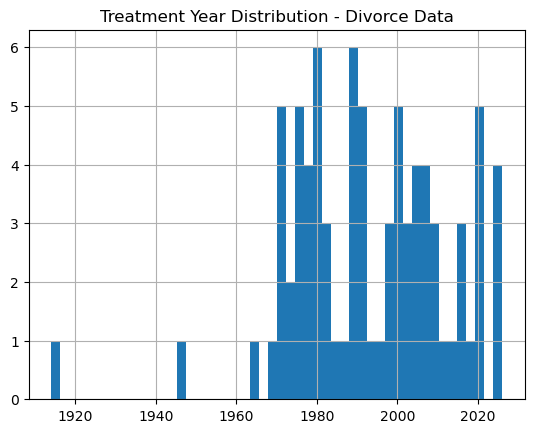

In [10]:
# visualize divorce year

divorce_data['Treatment Year'].hist(bins=50)
plt.title('Treatment Year Distribution - Divorce Data')
plt.show()

# Merge: CoResidence & Divorce Data

In [11]:
# anticipate merge failures

[country for country in df['Country Name'].unique() if country not in divorce_data['Country'].unique()]

['Congo, Dem. Rep.',
 'Czechia',
 'Egypt, Arab Rep.',
 'Gambia, The',
 'Iran, Islamic Rep.',
 'Korea, Rep.',
 'Lao PDR',
 'North Macedonia',
 'West Bank and Gaza',
 'Russian Federation',
 'Slovak Republic',
 'Venezuela, RB',
 'Viet Nam',
 'Yemen, Rep.']

In [12]:
# name mapper for improved merge:

country_name_mapper = {
    'Congo, Dem. Rep.':'Congo',
 'Czechia':'Czech Republic',
 'Egypt, Arab Rep.':'Egypt',
 'Gambia, The':'Gambia',
 'Iran, Islamic Rep.':'Iran',
 'Korea, Rep.':'South Korea',
 'Lao PDR':'Laos',
 'North Macedonia':'Macedonia',
 'West Bank and Gaza':'Palestine',
 'Russian Federation':'Russia',
 'Slovak Republic':'Slovakia',
 'Venezuela, RB':'Venezuela',
 'Viet Nam':'Vietnam',
 'Yemen, Rep.':'Yemen'
}

# reverse
country_name_mapper = {
    value:key for key, value in country_name_mapper.items()
}


In [13]:
# update names in right table to prepare for successful merge

divorce_data['Country'] = divorce_data['Country'].replace(country_name_mapper)


In [14]:
# merge with divorce data

df_mstr = df.merge(divorce_data, left_on='Country Name', right_on='Country', how='left')

In [15]:
df_mstr[df_mstr['Treatment Y/N'].isnull()]

,Country Name,Country Code,Year,Gini_recon_hybrid,Gini,Gini_missing,Country,Blame Based,Fault Comment,Irreconcilable Differences,No Fault Comment,Treatment Y/N,Treatment Year,Unnamed: 8,Fault Based,Mutual No Fault,Unilateral No Fault,Treatment


In [16]:
# drop columns
columns_to_drop = ['Unnamed: 8', 'Fault Based', 'Mutual No Fault', 'Unilateral No Fault']
df_mstr = df_mstr.drop(columns=columns_to_drop)

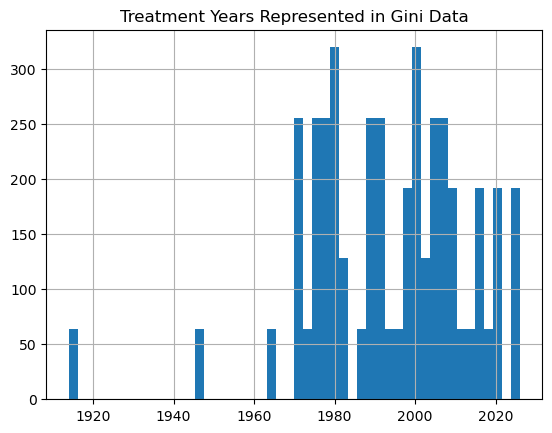

Percentage of observations ever treated: 55.00000000000001%


In [17]:
# Plot treatment years represented in merged data

df_mstr['Treatment Year'].hist(bins=50)
plt.title('Treatment Years Represented in Gini Data')
plt.show()

# size of treated vs. not treated, by year
percent_treated = df_mstr['Treatment Year'].notnull().sum()/len(df_mstr)
print(f"Percentage of observations ever treated: {round(percent_treated, 2)*100}%")

In [18]:
# create treatment cohorts

def treatment_cohort(treatment_year):
    """Takes treatment year and assigns to a cohort"""
    if pd.isna(treatment_year):
        return np.nan
    floor_decade = int((treatment_year)//10*10)
    ceiling_decade = floor_decade + 9
    treatment_cohort = f"{floor_decade}-{ceiling_decade}"
    return(treatment_cohort)
    

In [19]:
# create treatment cohorts using formula

df_mstr['Treatment Cohort'] = df_mstr['Treatment Year'].apply(lambda x: treatment_cohort(x))

print(f"Treatment Cohorts: {sorted(df_mstr['Treatment Cohort'].dropna().unique())}")

Treatment Cohorts: ['1910-1919', '1940-1949', '1960-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2019', '2020-2029']


In [20]:
# define viable countries as having both pre and post years when treated


viable_countries = df_mstr.groupby('Country', group_keys=False).apply(
    lambda x: (
        ((x['Treatment']==1) & (x['Year'] < x['Treatment Year'])).any()) and
    ((x['Treatment']==1) & (x['Year'] >= x['Treatment Year'])).any()
)

viable_countries_filtered = viable_countries[viable_countries]

In [21]:
# OnTreat column tracks which entities and years have received treatment

df_mstr['OnTreat'] = (
    (df_mstr['Year']>=df_mstr['Treatment Year']) 
    & df_mstr['Treatment'].eq(1)
).astype(int)


In [22]:
# validate that OnTreat diversity per country equals viable_countries_filtered


on_treat = df_mstr[df_mstr['Treatment']==1].groupby('Country')['OnTreat'].nunique()==2
on_treat_filtered = on_treat[on_treat]


In [23]:
# sanity check

assert on_treat_filtered.equals(viable_countries_filtered), "uh-oh"

In [24]:
# filter df_mstr down to appropriate countries only

df_mstr = df_mstr[df_mstr['Country'].isin(viable_countries_filtered.index)]


In [25]:
# viable cohorts have at least 30 rows of treated data

cohort_ontreat = (df_mstr.groupby('Treatment Cohort')['OnTreat'].agg('sum')>=30)
viable_cohorts = cohort_ontreat[cohort_ontreat].index
viable_cohorts

Index(['1960-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009',
       '2010-2019'],
      dtype='object', name='Treatment Cohort')

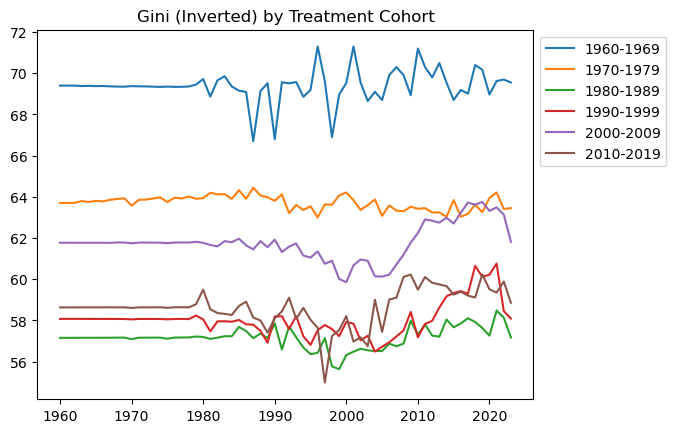

In [26]:
# visualize cohort trends

fig, ax = plt.subplots()

for cohort in viable_cohorts:
    
    annual_agg = (
        df_mstr[df_mstr['Treatment Cohort']==cohort]
        .groupby('Year', as_index=False).agg(Annual_Gini=('Gini_recon_hybrid', 'mean'))
    )
    x_axis = annual_agg['Year']
    y_axis = annual_agg['Annual_Gini']

    plt.plot(x_axis, y_axis, label = cohort)
    plt.legend(bbox_to_anchor=(1,1))

plt.title("Gini (Inverted) by Treatment Cohort")
plt.show()

# Staggered DiD

In [27]:
# create a copy of the master data 

df_did = df_mstr.copy()

In [28]:
# DiD

# initiate dictionaries to store results
results = {}
warn_log = {}
custom_summary = []

Y = 'Gini_recon_hybrid'
target = 'Treatment:OnTreat'

for cohort in viable_cohorts:
    print(cohort)
    treated_mask = df_did['Treatment Cohort']==cohort #all cohorts by definition are treated
    treated = df_did[treated_mask]

    benchmark_year = treated['Treatment Year'].mode().iat[0] #treatment year per cohort
    
    # control groups:
    # never treated & not-yet-treated (where years come before treatment)
    never_treated_mask = df_did['Treatment']== 0
    not_yet_treated_mask = (df_did['Treatment Year'].gt(benchmark_year) 
                            & df_did['Year'].lt(df_did['Treatment Year']))
    control_mask = never_treated_mask | not_yet_treated_mask
                            
    subset = df_did.loc[treated_mask | control_mask].copy()
    
    # identify countries with fewer than 2 observations
    singleton_countries = subset['Country'].value_counts().loc[lambda x: x<2]
    
    # drop singleton countries
    subset = subset[~subset['Country'].isin(singleton_countries)].copy()
    
    # DiD formula
    formula = f"{Y} ~ Treatment:OnTreat + C(Year) + C(Country)"
    
    

    result = smf.ols(formula=formula, data=subset).fit(
    cov_type = 'cluster',
    cov_kwds = {'groups': subset['Country']})
        

    
    # collect results in dictionary
    results[cohort] = result

    # generate DiD stats
    coef = result.params.get(target, np.nan)
    se = result.bse.get(target, np.nan)
    tval = result.tvalues.get(target, np.nan)
    pval = result.pvalues.get(target, np.nan)
    
    if (not np.isfinite(se)) or (se==0):
        warn_log.setdefault(cohort, []).append(
            f"SE invalid (se={se}); clusters={subset['Country'].nunique()}"
        )
        
    # gather DiD stats
    custom_summary.append({
        "cohort" : cohort,
        "coef": coef,
        "se":se,
        "tval": tval,
        "pval": pval
    }
    )

1960-1969
1970-1979
1980-1989
1990-1999
2000-2009
2010-2019


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [29]:
# inspect custom summary
custom_summary = pd.DataFrame(custom_summary)
custom_summary

,cohort,coef,se,tval,pval
0,1960-1969,0.254561,0.113652,2.239819,0.025103
1,1970-1979,0.375001,0.200944,1.866196,0.062014
2,1980-1989,0.424804,0.276705,1.535224,0.124729
3,1990-1999,0.434416,0.367906,1.180780,0.237690
4,2000-2009,0.308369,0.439197,0.702120,0.482604
5,2010-2019,1.436659,0.976666,1.470983,0.141296


In [30]:
# inspect warnings for DiD term
warn_log

{}

# Panel OLS

In [31]:
# create a copy
df_panel = df_mstr.copy()


In [32]:
# set index as required by panel ols
df_panel = df_panel.set_index(['Country', 'Year'])

In [33]:
for cohort in viable_cohorts:
    print(cohort)

1960-1969
1970-1979
1980-1989
1990-1999
2000-2009
2010-2019


In [34]:
# try with panel ols

panel_results = {}
panel_summary = []

for cohort in viable_cohorts:
    print(cohort)
    
    benchmark_year = df_panel.loc[df_panel['Treatment Cohort']==cohort, 'Treatment Year'].mode().iat[0]
    print(benchmark_year)
    
    treated_mask = df_panel['Treatment Cohort'] == cohort
    
    never_treated_mask = df_panel['Treatment'] == 0
    not_yet_treated_mask = (
        (df_panel['Treatment Year'] > benchmark_year) & 
        (df_panel.index.get_level_values('Year') < df_panel['Treatment Year'])
    )
    
    control_mask = never_treated_mask | not_yet_treated_mask
    
    es_cols = ['OnTreat']
    
    subset = df_panel.loc[treated_mask | control_mask, es_cols]
    
    y = df_panel.loc[subset.index, 'Gini_recon_hybrid']
    X = subset.copy()
    
    model = PanelOLS(y, X, entity_effects=True, time_effects=True)
    result = model.fit(cov_type='clustered', cluster_entity=True, cluster_time=False)
    
    panel_results[cohort] = result
    
    # build custom summary
    panel_summary.append(
        {
        'cohort':cohort,
        'coefficient': result.params.iat[0],
        'standard error': result.std_errors.iat[0],
        'p_value': result.pvalues.iat[0],
        't_value': result.tstats.iat[0]
    }
    )
    

1960-1969
1965.0
1970-1979
1977.0
1980-1989
1980.0
1990-1999
1992.0
2000-2009
2001.0
2010-2019
2016.0


In [35]:
panel_summary = pd.DataFrame(panel_summary)

panel_summary

,cohort,coefficient,standard error,p_value,t_value
0,1960-1969,0.254561,0.112758,0.024077,2.257584
1,1970-1979,0.375001,0.199326,0.060033,1.881346
2,1980-1989,0.424804,0.273806,0.120934,1.551479
3,1990-1999,0.434416,0.363123,0.231714,1.196334
4,2000-2009,0.308369,0.431118,0.474544,0.715278
5,2010-2019,1.436659,0.927283,0.121874,1.549321


In [36]:
side_by_side = pd.DataFrame(pd.concat([custom_summary, panel_summary], axis=1))
side_by_side

,cohort,coef,se,tval,pval,cohort,coefficient,standard error,p_value,t_value
0,1960-1969,0.254561,0.113652,2.239819,0.025103,1960-1969,0.254561,0.112758,0.024077,2.257584
1,1970-1979,0.375001,0.200944,1.866196,0.062014,1970-1979,0.375001,0.199326,0.060033,1.881346
2,1980-1989,0.424804,0.276705,1.535224,0.124729,1980-1989,0.424804,0.273806,0.120934,1.551479
3,1990-1999,0.434416,0.367906,1.180780,0.237690,1990-1999,0.434416,0.363123,0.231714,1.196334
4,2000-2009,0.308369,0.439197,0.702120,0.482604,2000-2009,0.308369,0.431118,0.474544,0.715278
5,2010-2019,1.436659,0.976666,1.470983,0.141296,2010-2019,1.436659,0.927283,0.121874,1.549321


## Summary

Staggered DiD regressions per cohort revealed statistically significant effects for two cohorts: 
1) **1960-1969** - coef: 0.25 (pval 0.02)
2) **1970-1979** - coef: 0.20 (pval 0.06)

Gini values have been previously inverted to improve interpretability. Normally, high Gini values indicate high levels of inequality. Thus, a positive coefficient corresponds to a decrease in Gini values, and a decrease in wealth inequality.

Unfortunately, staggered cohorts require assigning a 'Treatment Year' per cohort, which is the mode of the treatment years in that cohort. By definition, benchmarking to the mode year will capture most of the treatment years in the cohort. However, this will also contaminate data, which does not have the mode treatment year.

Binning cohorts in the case of my dataset was a preliminary step. 

# Event Study - Manual ATT

In [37]:
# copy mstr df and create relative year column

df_es = df_mstr.copy()

# create a "relative year" column for observations and bin the tails

df_es['rel_year'] = (df_es['Year'] - df_es['Treatment Year'])


In [38]:
df_es['Year'].value_counts().sort_index()

1960    62
1961    62
1962    62
1963    62
1964    62
        ..
2019    62
2020    62
2021    62
2022    62
2023    62
Name: Year, Length: 64, dtype: int64

In [39]:
# plot ATT per e

cell_dict = []
countries = viable_countries_filtered.index

for country in countries:
    # treatment year
    Gi = df_es.loc[df_es['Country']==country, 'Treatment Year'].iat[0]
    
    # e = -1 (baseline year)
    t_0 = Gi - 1
    
    treated_t0_mask = ((df_es['Treatment']==1) & (df_es['Country']==country) & (df_es['Year']==t_0))
        
    treated_t0 = df_es.loc[treated_t0_mask, 'Gini_recon_hybrid'].iat[0]
    
    control_t0_mask = (
            (df_es['Year']==t_0) &
            ((df_es['Treatment']==0) | ((df_es['Treatment']==1) & (df_es['Treatment Year'] > t_0))) &
            (df_es['Country']!= country) &
            (df_es['Treatment Year']!= Gi)
        )
    
    
    s_t0 = df_es.loc[control_t0_mask, 'Gini_recon_hybrid']
    control_t0 = s_t0.mean() if s_t0.notna().any() else np.nan
        

    # event time list
    e_list = list(df_es.loc[df_es['Country']==country, 'rel_year'])

    
    for e in e_list:
        # event time (calendar year at e)
        t_i = df_es.loc[((df_es['Country']==country) & (df_es['rel_year']==e)), 'Year'].iat[0]

        
        # gini value at calendar year at e
        treated_ti_mask = ((df_es['Treatment']==1) & (df_es['Country']==country) & (df_es['Year']==t_i))
        
        treated_ti = df_es.loc[treated_ti_mask, 'Gini_recon_hybrid'].iat[0]
        
        # calendar time mask
        control_ti_mask = (
            (df_es['Year'] == t_i) &
            ((df_es['Treatment'] == 0) | ((df_es['Treatment'] == 1) & (df_es['Treatment Year'] > t_i))) &
            (df_es['Country'] != country)  &
            (df_es['Treatment Year'] != Gi)
        )
        
            
#         # purge control_ti of any years where mask is empty  
        s_ti = df_es.loc[control_ti_mask, 'Gini_recon_hybrid']
        control_ti = s_ti.mean() if s_ti.notna().any() else np.nan
        
        #print(e, control_ti)
        
        
        # # store results
        cell_dict.append({
            'country': country,
            'event_time_i': e,
            'treatment_year': Gi,
            'calendar_year(ti)': t_i,
            'treated_ti': treated_ti,
            'treated_t0': treated_t0,
            'control_ti': control_ti,
            'control_t0': control_t0
        })


In [40]:
# save results in a dataframe

cell_df = pd.DataFrame(cell_dict)

cell_df

,country,event_time_i,treatment_year,calendar_year(ti),treated_ti,treated_t0,control_ti,control_t0
0,Argentina,-56.0,2016.0,1960,54.347031,55.388731,61.001315,64.008739
1,Argentina,-55.0,2016.0,1961,54.347031,55.388731,61.001315,64.008739
2,Argentina,-54.0,2016.0,1962,54.347031,55.388731,61.001315,64.008739
3,Argentina,-53.0,2016.0,1963,54.373400,55.388731,61.028109,64.008739
4,Argentina,-52.0,2016.0,1964,54.360914,55.388731,61.015423,64.008739
...,...,...,...,...,...,...,...,...
3963,Zimbabwe,32.0,1987.0,2019,49.700000,54.378446,64.010282,59.783476
3964,Zimbabwe,33.0,1987.0,2020,53.866062,54.378446,65.415366,59.783476
3965,Zimbabwe,34.0,1987.0,2021,54.280660,54.378446,NaN,59.783476
3966,Zimbabwe,35.0,1987.0,2022,54.079433,54.378446,NaN,59.783476


In [41]:
# create an ATT column in cell_df

ATT = (cell_df['treated_ti'] - cell_df['treated_t0']) - (cell_df['control_ti'] - cell_df['control_t0'])

 
cell_df['ATT'] = ATT

# create a binned event time column

cell_df['event_time_binned'] = cell_df['event_time_i'].clip(-5, 5)

In [42]:
# average over e

event_time_att = (
    cell_df.groupby('event_time_binned', as_index=False)
    .agg(
        cell_mean=('ATT', 'mean'),
        n_cells = ('ATT', 'size')
    ).dropna()
)
    
event_time_att.head()


,event_time_binned,cell_mean,n_cells
0,-5.0,0.581526,1867
1,-4.0,0.145959,62
2,-3.0,0.345137,62
3,-2.0,0.013533,62
4,-1.0,0.000000,62


In [43]:
cell_df.head()

,country,event_time_i,treatment_year,calendar_year(ti),treated_ti,treated_t0,control_ti,control_t0,ATT,event_time_binned
0,Argentina,-56.0,2016.0,1960,54.347031,55.388731,61.001315,64.008739,1.965724,-5.0
1,Argentina,-55.0,2016.0,1961,54.347031,55.388731,61.001315,64.008739,1.965724,-5.0
2,Argentina,-54.0,2016.0,1962,54.347031,55.388731,61.001315,64.008739,1.965724,-5.0
3,Argentina,-53.0,2016.0,1963,54.373400,55.388731,61.028109,64.008739,1.965299,-5.0
4,Argentina,-52.0,2016.0,1964,54.360914,55.388731,61.015423,64.008739,1.965499,-5.0


In [44]:
# bootstrap confidence intervals for plot

n_draws = 500
rng = np.random.default_rng(21) #in lieu of np.random.seed()

countries = cell_df['country'].dropna().unique()

draws = []


for n in range(n_draws):
    sample = rng.choice(countries, size=len(countries), replace=True)
    w = pd.Series(sample).value_counts().rename('w')
    
    wsub = cell_df.merge(w, left_on='country', right_index=True, how='inner')
    

    wsub['w_ATT'] = wsub['ATT'] * wsub['w']
    

    
    # 500 sets of ATT numbers, based on random country selections
    # For each set, for each e, calculate weighted average ATT
    bootstrap_att = (
        wsub.dropna(subset=['ATT'])
        .groupby('event_time_binned', as_index=False)
        .agg(weighted_sum = ('w_ATT', 'sum'),
            w_total = ('w', 'sum'))
        .assign(wavg_ATT = lambda x: x['weighted_sum']/x['w_total'],
               draw = n)
    )
    
    # amass average ATT in lists per e
    for e, att, draw in bootstrap_att[['event_time_binned', 'wavg_ATT', 'draw']].itertuples(index=False):
        draws.append({
            'e': e, 'weighted_avg_att': att, 'draw': draw
        })
    
    draws_df = pd.DataFrame(draws) 

    ci = (
        draws_df.groupby('e')['weighted_avg_att']
        .quantile([0.025, 0.975])
        .unstack()
        .rename(columns={0.025:'ci_low', 0.975:'ci_high'})
        .reset_index()
    )
    
ci


,e,ci_low,ci_high
0,-5.0,-0.137520,1.253692
1,-4.0,-0.272967,0.574686
2,-3.0,-0.072923,0.838123
3,-2.0,-0.545506,0.541503
4,-1.0,0.000000,0.000000
5,0.0,-0.446196,0.501620
6,1.0,-0.182967,0.726865
7,2.0,-0.437020,0.658297
8,3.0,-0.454344,0.841674
9,4.0,-0.613348,0.621381


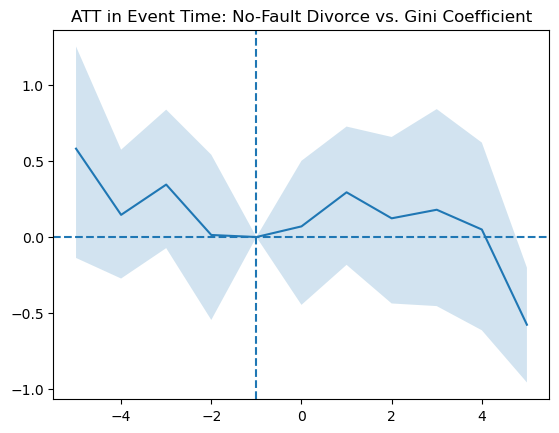

In [45]:
# plot ATT in Event Time

fig, ax = plt.subplots()

x_axis = event_time_att['event_time_binned']
y_axis = event_time_att['cell_mean']

plt.axvline(-1, linestyle='--')
plt.axhline(0, linestyle='--')

plt.plot(x_axis, y_axis)

#ci
x_axis_b = ci['e']
plt.fill_between(x_axis_b, ci['ci_low'], ci['ci_high'], alpha=0.2, label="95% CI")

plt.title("ATT in Event Time: No-Fault Divorce vs. Gini Coefficient")
plt.show()



# Event Study with Patsy Contrasts

In [42]:
# assign -1 value to NaN rows in rel_year
# since -1 is the baseline
df_es['rel_year_es'] = df_es['rel_year'].replace(np.NaN, -1)

Y = "Gini_recon_hybrid"

# use rel_year_es instead of OnTreat
formula = f"{Y} ~ C(rel_year_es, CTR(reference=-1)) + C(Country) + C(Year)"

results = smf.ols(formula=formula, data=df_es).fit(
    cov_type = 'cluster',
    cov_kwds = {"groups":df_es['Country']}
)

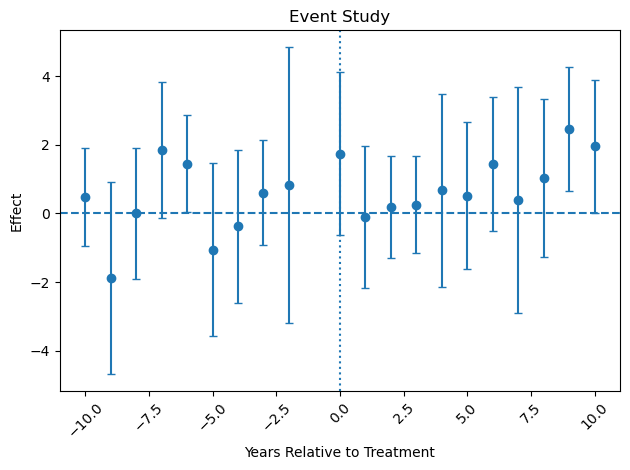

In [43]:
# event study plot

coefs = results.params.filter(like='rel_year_es')
ses = results.bse.filter(like='rel_year_es')

coefs_names = [int(float(s.split("T.")[1].rstrip(']'))) for s in coefs.index]

event_df = pd.DataFrame({
    'Relative Time': coefs_names,
    'Coefficient':coefs.values,
    'Standard Error':ses.values
})

event_df = event_df.sort_values(by='Relative Time', ascending=True)

event_df

# # plot the results

fig, ax = plt.subplots()
plt.axhline(0, linestyle='--')
plt.axvline(0, linestyle=':')

plt.errorbar(
    x = event_df['Relative Time'], y = event_df['Coefficient'], yerr=1.96*event_df['Standard Error'],
    fmt='o', capsize=3
)
plt.xlabel('Years Relative to Treatment')
plt.ylabel('Effect')
plt.title("Event Study")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
# repeat with different bin mapping
# bin mappings meant to improve thin k

def bin_rel_year(rel_year):
    if pd.isna(rel_year): return np.NaN
    if rel_year <= -6: return "pre_tail"
    elif -5 <= rel_year <= -3: return "pre_3to5"
    elif rel_year == -2: return "pre_2"
    elif rel_year == -1: return "baseline"
    elif 0 <= rel_year <= 2: return "post_0to2"
    elif 3 <= rel_year <=4: return "post_3to4"
    elif 5 <= rel_year <=6: return "post_5to6"
    else: return "post_tail"

In [51]:
# create a relative year binned column with bins

df_es['rel_year_binned'] = df_es['rel_year'].map(bin_rel_year)

In [52]:
# create a relative year binned event study column with NaN subsumed under baseline

df_es['rel_year_bines'] = np.where(pd.isna(df_es['rel_year_binned']), 'baseline', df_es['rel_year_binned'])

In [53]:
# validate bins
df_es['rel_year_bines'].value_counts(dropna=False).sort_index()

baseline     246
post_0to2     16
post_3to4     10
post_5to6     13
post_tail    215
pre_2          8
pre_3to5      15
pre_tail     106
Name: rel_year_bines, dtype: int64

In [60]:
# try event study with modified bins

Y = 'Gini_recon_hybrid'

formula = f"{Y} ~ C(rel_year_bines, CTR(reference='baseline')) + C(Country) + C(Year)"

results = (
    smf.ols(formula=formula, data=df_es)
    .fit(
        cov_type='cluster',
        cov_kwds={'groups':df_es['Country']}
    )
)

In [63]:
#results.params.filter(like='rel_year_bines')
results.pvalues.filter(like='rel_year_bines')

C(rel_year_bines, CTR(reference='baseline'))[T.post_0to2]    0.441032
C(rel_year_bines, CTR(reference='baseline'))[T.post_3to4]    0.562225
C(rel_year_bines, CTR(reference='baseline'))[T.post_5to6]    0.264291
C(rel_year_bines, CTR(reference='baseline'))[T.post_tail]    0.030002
C(rel_year_bines, CTR(reference='baseline'))[T.pre_2]        0.708259
C(rel_year_bines, CTR(reference='baseline'))[T.pre_3to5]     0.887089
C(rel_year_bines, CTR(reference='baseline'))[T.pre_tail]     0.373083
dtype: float64

# Event Study with Manual Dummies